## Lab 4 - part 2: Data Weights and Autocorellation

**TU Delft and WUR**<br>
**Q1 2024**<br>
**Instructor:** Theodoros Chatzivasileiadis <br>
**Instructor:** Hans Hoogenboom <br>
**TA:** Ka Yi Chua <br>
**[Metropolitan Data 1](https://jhoogenboom.github.io/spatial-data-science/_index.html)** <br>



## Exercise 4a: Spatial Autocorrelation and ESDA 

USE the Liverpool IMD data we have been using in previous sessions. This will require you to:

* Load up the IMD dataset for Liverpool.
* Create a choropleth of the `imd_score` variable.
* Compute the spatial weights matrix for the LSOAs. Think of one criterium to build it that you think would fit this variable (e.g. contiguity, distance-based, etc.), and apply it.
* Create the standardized version of the IMD scores.
* Calculate the spatial lag of the standardized scores.
* Create the Moran Plot.
* Calculate the value of Moran's I as well as its significance level.
* Perform a LISA analysis and generate a map of the results. What are the main patterns?

In [21]:
# your code here 
import osmnx as ox, geopandas as gpd
import pandas as pd #import libraries
import numpy as np
import seaborn as sns

ox.settings.log_console=True
ox.settings.use_cache=True

from pysal.lib import weights
from pysal.explore import esda
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation
import contextily as ctx
import matplotlib.pyplot as plt

np.random.seed(123)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/spaghetti/network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [53]:
#df = pd.read_csv('data/IMD/OAs/OA11_LSOA11_MSOA11_LAD11_EW_LUv2.csv') #loading the csv file
#df #explore head and tail

lookup_path = 'data/IMD/'
file_name = 'lab04_imd.shp'
df = gpd.read_file('data/IMD/lab04_imd.shp')

df.head()

,lsoa11cd,lsoa11nm,lsoa11nmw,st_areasha,st_lengths,IMD_Rank,IMD_Decile,LSOA01NM,LADcd,LADnm,...,IndDec,OutScore,OutRank,OutDec,TotPop,DepChi,Pop16_59,Pop60+,WorkPop,geometry
0,E01000001,City of London 001A,City of London 001A,133320.768872,2291.846072,29199,9,City of London 001A,E09000001,City of London,...,5,1.503,1615,1,1296,175,656,465,715.00,"POLYGON ((532105.092 182011.230, 532162.491 18..."
1,E01000002,City of London 001B,City of London 001B,226191.272990,2433.960112,30379,10,City of London 001B,E09000001,City of London,...,7,1.196,2969,1,1156,182,580,394,619.75,"POLYGON ((532746.813 181786.891, 532671.688 18..."
2,E01000003,City of London 001C,City of London 001C,57302.966538,1142.359799,14915,5,City of London 001C,E09000001,City of London,...,6,2.207,162,1,1350,146,759,445,804.00,"POLYGON ((532135.145 182198.119, 532158.250 18..."
3,E01000005,City of London 001E,City of London 001E,190738.760504,2167.868343,8678,3,City of London 001E,E09000001,City of London,...,8,1.769,849,1,1121,229,692,200,683.00,"POLYGON ((533807.946 180767.770, 533649.063 18..."
4,E01000006,Barking and Dagenham 016A,Barking and Dagenham 016A,144195.846857,1935.510354,14486,5,Barking and Dagenham 016A,E09000002,Barking and Dagenham,...,5,0.969,4368,2,2040,522,1297,221,1284.50,"POLYGON ((545122.049 184314.931, 545271.917 18..."


In [55]:
type(df)

geopandas.geodataframe.GeoDataFrame

In [57]:
df1 = df.loc[df['LADnm'] == 'Liverpool',:]
df1.head()

,lsoa11cd,lsoa11nm,lsoa11nmw,st_areasha,st_lengths,IMD_Rank,IMD_Decile,LSOA01NM,LADcd,LADnm,...,IndDec,OutScore,OutRank,OutDec,TotPop,DepChi,Pop16_59,Pop60+,WorkPop,geometry
6348,E01006512,Liverpool 031A,Liverpool 031A,283906.863775,3063.168774,14664,5,Liverpool 031A,E08000012,Liverpool,...,1,0.536,8031,3,2975,255,2639,81,2649.50,"POLYGON ((335888.000 390042.000, 336203.000 39..."
6349,E01006513,Liverpool 060A,Liverpool 060A,555037.185423,5835.725743,11173,4,Liverpool 060A,E08000012,Liverpool,...,1,0.974,4329,2,4418,103,4222,93,4257.75,"POLYGON ((335374.808 390547.998, 335405.406 39..."
6350,E01006514,Liverpool 037A,Liverpool 037A,262030.747956,3243.503128,3299,2,Liverpool 037A,E08000012,Liverpool,...,1,0.550,7888,3,1760,87,1439,234,1538.25,"POLYGON ((335650.536 389928.121, 335677.916 38..."
6351,E01006515,Liverpool 037B,Liverpool 037B,366499.754871,4273.694263,1875,1,Liverpool 037B,E08000012,Liverpool,...,3,0.615,7285,3,1438,176,1013,249,1014.75,"POLYGON ((335178.000 389642.000, 335222.397 38..."
6352,E01006518,Liverpool 044A,Liverpool 044A,235181.260598,2743.746370,330,1,Liverpool 044A,E08000012,Liverpool,...,2,0.564,7747,3,1732,287,971,474,993.00,"POLYGON ((335528.316 389067.946, 335612.896 38..."


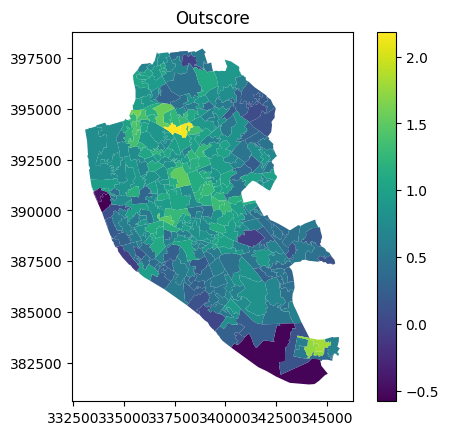

In [61]:
df1.plot(column = 'OutScore', legend = True)
plt.title('Outscore')
plt.show()

In [65]:
%time w = weights.Queen.from_dataframe(df1, ids='lsoa11cd')

CPU times: user 28.3 ms, sys: 4.78 ms, total: 33.1 ms
Wall time: 38.5 ms


In [66]:
w['E01006512']

{'E01006751': 1.0,
 'E01033768': 1.0,
 'E01006679': 1.0,
 'E01006513': 1.0,
 'E01033757': 1.0,
 'E01006673': 1.0}

/var/folders/c3/71m7w1k51m356vg23mpnvxn00000gn/T/ipykernel_91868/4000493826.py:2: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  df1.loc[w.islands, :].plot(color='red', ax=ax);


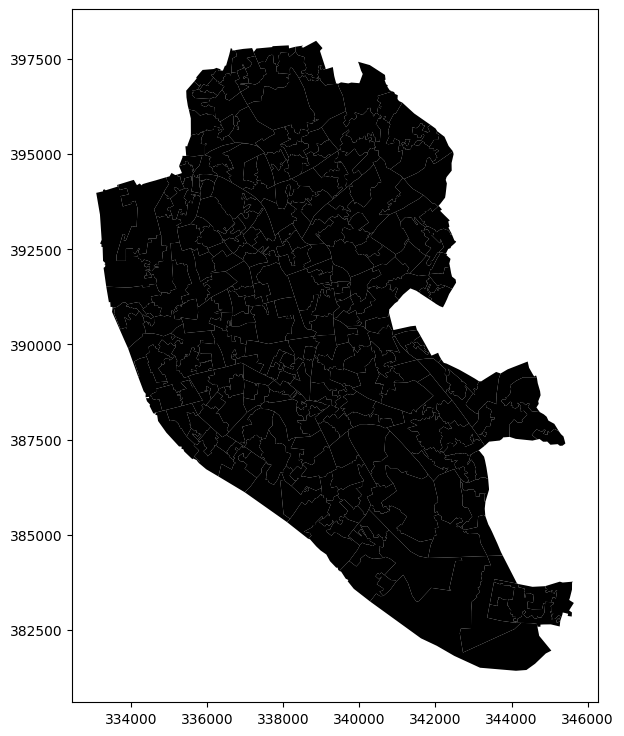

In [67]:
ax = df1.plot(color='k', figsize=(9, 9))
df1.loc[w.islands, :].plot(color='red', ax=ax);

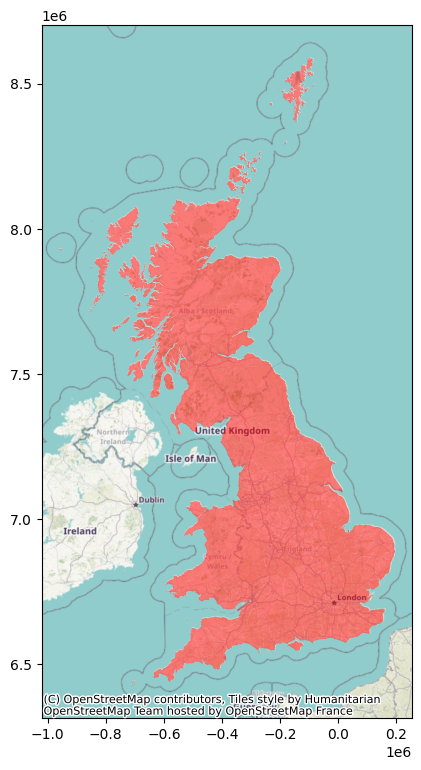

In [35]:
gpkg_file = 'data/brexit.gpkg'

#Load local Authority geometries using their ID code as index
gpkg = gpd.read_file(gpkg_file).set_index('LAD14CD', drop=False)
ax = gpkg.plot(figsize=(9, 9), alpha=.5, color='red');
# Add background map, expressing target CRS so the basemap can be
# reprojected (warped)
ctx.add_basemap(ax, crs=gpkg.crs)

In [32]:
gpkg

,OBJECTID,LAD14CD,LAD14NM,LAD14NMW,id,Region_Cod,Region,Area,Electorate,ExpectedBa,...,Leave,Rejected_B,No_officia,Voting_for,Writing_or,Unmarked_o,Pct_Remain,Pct_Leave,Pct_Reject,geometry
LAD14CD,,,,,,,,,,,,,,,,,,,,,
E06000001,1,E06000001,Hartlepool,None,70,E12000001,North East,Hartlepool,70341,46137,...,32071,34,0,12,6,16,30.43,69.57,0.07,"MULTIPOLYGON (((-141202.225 7308889.307, -1411..."
E06000002,2,E06000002,Middlesbrough,None,71,E12000001,North East,Middlesbrough,94612,61395,...,40177,35,0,16,1,18,34.52,65.48,0.06,"MULTIPOLYGON (((-139272.615 7282988.170, -1390..."
E06000003,3,E06000003,Redcar and Cleveland,None,72,E12000001,North East,Redcar and Cleveland,103529,72741,...,48128,27,0,6,0,21,33.81,66.19,0.04,"MULTIPOLYGON (((-126494.218 7293275.078, -1264..."
E06000004,4,E06000004,Stockton-on-Tees,None,73,E12000001,North East,Stockton-on-Tees,141486,100462,...,61982,45,2,13,2,28,38.27,61.73,0.04,"MULTIPOLYGON (((-146637.970 7293230.452, -1466..."
E06000005,5,E06000005,Darlington,None,74,E12000001,North East,Darlington,77662,55194,...,30994,29,0,0,0,29,43.82,56.18,0.05,"MULTIPOLYGON (((-182304.320 7287910.300, -1823..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W06000020,376,W06000020,Torfaen,Torfaen,144,W92000004,Wales,Torfaen,68957,48177,...,28781,28,0,11,2,15,40.22,59.78,0.06,"MULTIPOLYGON (((-345635.080 6763150.388, -3452..."
W06000021,377,W06000021,Monmouthshire,Sir Fynwy,145,W92000004,Wales,Monmouthshire,71607,55670,...,27569,40,19,0,0,21,50.44,49.56,0.07,"MULTIPOLYGON (((-309498.054 6714796.598, -3095..."
W06000022,378,W06000022,Newport,Casnewydd,146,W92000004,Wales,Newport,104977,73708,...,41236,59,3,29,2,25,44.01,55.99,0.08,"MULTIPOLYGON (((-315773.612 6736982.410, -3157..."


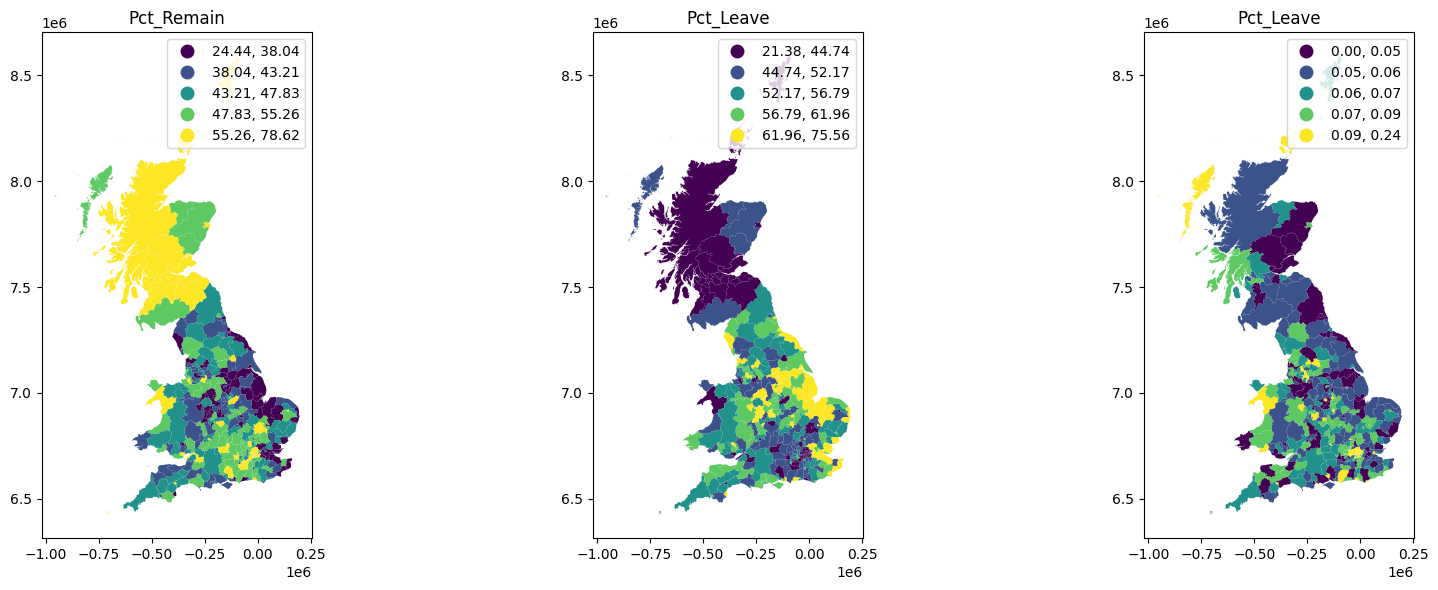

In [42]:
# Create a figure and 3 subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Adjust size as needed

# Plot with BoxPlot classification scheme
gpkg.plot(column='Pct_Remain', scheme='Quantiles', legend=True, ax=axes[0])
axes[0].set_title('Pct_Remain')

# Plot with EqualInterval classification scheme
gpkg.plot(column='Pct_Leave', scheme='Quantiles', k=5, legend=True, ax=axes[1])
axes[1].set_title('Pct_Leave')

# Plot with Quantiles classification scheme
gpkg.plot(column='Pct_Reject', scheme='Quantiles', k=5, legend=True, ax=axes[2])
axes[2].set_title('Pct_Leave')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

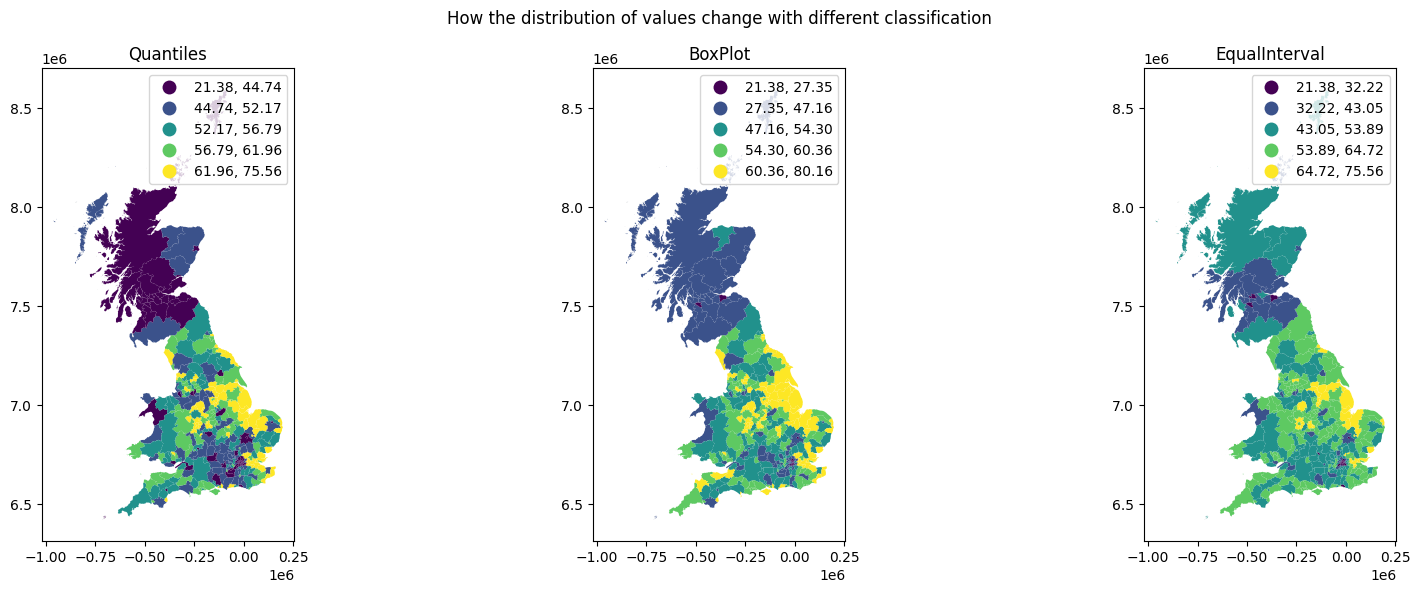

In [47]:
# Create a figure and 3 subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Adjust size as needed

# Plot with BoxPlot classification scheme
gpkg.plot(column='Pct_Leave', scheme='Quantiles', legend=True, ax=axes[0])
axes[0].set_title('Quantiles')

# Plot with EqualInterval classification scheme
gpkg.plot(column='Pct_Leave', scheme='BoxPlot', k=5, legend=True, ax=axes[1])
axes[1].set_title('BoxPlot')

# Plot with Quantiles classification scheme
gpkg.plot(column='Pct_Leave', scheme='EqualInterval', k=5, legend=True, ax=axes[2])
axes[2].set_title('EqualInterval')

plt.suptitle('How the distribution of values change with different classification')
# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


In [ ]:
# Create the spatial weights matrix
# NOTE: this might take a few minutes as the geometries are
#       are very detailed
%time w = weights.Queen.from_dataframe(br, idVariable='LAD14CD')

For this part I would like you to experiment with Data from Amstedam. However this will require you to find the dataset yourself!

## Question 1: Building a Contiguity-Based Weight Matrix

Use PySAL to create a contiguity-based weight matrix (W) for a given spatial dataset of polygons. Write a function create_contiguity_weights that:

    Reads in a shapefile of polygons.
    Constructs a Queen contiguity-based spatial weights matrix.
    Returns the weight matrix.

## Question 2: Calculating Moran’s I

Write a function calculate_morans_i that:

    Takes a spatial weight matrix W and an attribute array y.
    Calculates Moran’s I for the given attribute array.
    Returns the Moran’s I value and its p-value.

## Question 3: Standardizing Spatial Weight Matrices

Create a function standardize_weights that:

    Takes a spatial weight matrix W.
    Standardizes it so that the weights of each row sum to one.
    Returns the standardized weight matrix.

## Question 4: Creating Distance-Based Weights

Write a function create_distance_weights that:

    Takes a set of point coordinates and a threshold distance.
    Constructs a distance-based spatial weight matrix where all points within the threshold distance are assigned a weight.
    Returns the weight matrix.

## Question 5: Visualizing a Moran Plot

Using PySAL, write a function plot_moran that:

    Takes a spatial weights matrix W and an attribute array y.
    Creates and displays a Moran plot for the attribute.
    Saves the Moran plot as an image file.

In [ ]:
# your code here (Edwin - Question 1)


In [ ]:
# your code here (Heqnes - Question 2)


In [ ]:
# your code here (Mannan - Question 3)


In [ ]:
# your code here (Nils - Question 4)


In [ ]:
# your code here (Renee - Question 5)
